Dataset figure

(270, 480, 3)
(540, 960, 3)


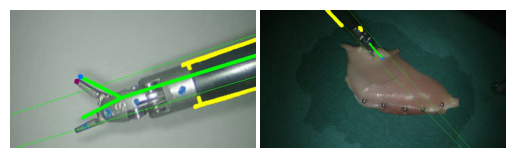

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2

d1 = cv2.imread('jrn_li.png')
#d2 = cv2.imread('dtd_endpi.png')
d2 = cv2.imread('dtd_li.png')

print(d1.shape)
print(d2.shape)

d1_cropped = d1[100:300, 115:400, :]
d2_cropped = d2[0:275, 225:510, :]

fig, ax = plt.subplots(nrows=1, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0].imshow(d1) 
ax[0].axis('off')
ax[1].imshow(d2)
ax[1].axis('off')

plt.subplots_adjust(wspace = 0.02)
plt.savefig('dataset_images.pdf', bbox_inches = 'tight')



Heatmap Figure

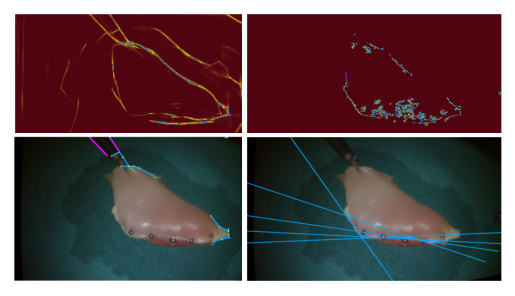

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2

img1 = cv2.imread('dtd_sold2lineheatmap.png')
img1 *= 4
#img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
img2 = cv2.imread('dtd_sold2linedetection_v3.png')


img3 = cv2.imread('dtd_cannyedgedetection.png')
img3 *= 4
img4 = cv2.imread('dtd_cannyedgelines.png')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(nrows=2, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0, 0].imshow(img1) 
ax[0, 0].axis('off')
#ax[0, 0].set_title('SOLD2', fontsize = 6)
ax[0, 1].imshow(img3)
ax[0, 1].axis('off')
#ax[0, 1].set_title('Canny', fontsize = 6)
ax[1, 0].imshow(img2)
ax[1, 0].axis('off')
ax[1, 1].imshow(img4)
ax[1, 1].axis('off')

plt.subplots_adjust(hspace = -0.5, wspace = -0.12)
plt.savefig('shaft_detection.pdf', bbox_inches = 'tight')


Experimental Screenshots Figure

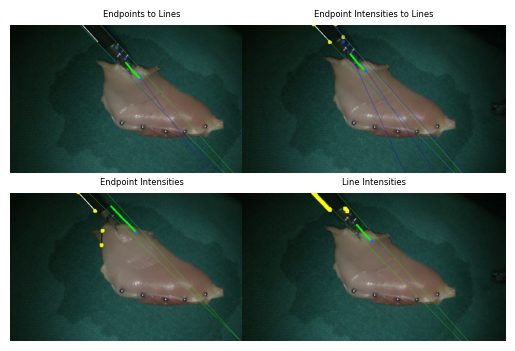

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


img1 = cv2.imread('endp2p.png')
img2 = cv2.imread('endpi2p.png')

img3 = cv2.imread('li.png')
img4 = cv2.imread('endpi.png')


fig, ax = plt.subplots(nrows=2, ncols=2)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0, 0].imshow(img1) 
ax[0, 0].axis('off')
ax[0, 0].set_title('Endpoints to Lines', fontsize = 6)
ax[0, 1].imshow(img2)
ax[0, 1].axis('off')
ax[0, 1].set_title('Endpoint Intensities to Lines', fontsize = 6)
ax[1, 1].imshow(img3)
ax[1, 1].axis('off')
ax[1, 1].set_title('Line Intensities', fontsize = 6)
ax[1, 0].imshow(img4)
ax[1, 0].axis('off')
ax[1, 0].set_title('Endpoint Intensities', fontsize = 6)

plt.subplots_adjust(hspace = -0.17, wspace = -0.12)
plt.savefig('qualitative_results.pdf', bbox_inches = 'tight')

Experimental Detections Figure

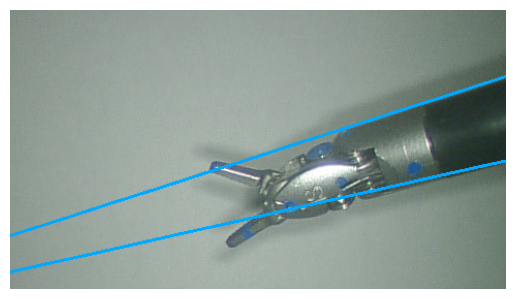

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2
import math

img1 = cv2.imread('ref_data/no_contour/ref_left_img.jpg')

grey = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
edges_and_mask = cv2.bitwise_and(edges, mask)
lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = 5, theta = 0.09, threshold = 150) 
lines = np.squeeze(lines)
# sort by max votes
sorted_lines = lines[(-lines[:, 2]).argsort()]
for i in range(sorted_lines.shape[0]):
    rho = sorted_lines[i, 0]
    theta = sorted_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(img1, pt1, pt2, (0,168,255), 2)
plt.axis('off')
plt.imshow(img1)
plt.savefig('jrn_canny.png', bbox_inches = 'tight')

In [18]:
!source /opt/ros/noetic/setup.bash

import time
import rospy
import cv2
import kornia as K
import kornia.feature as KF
import rosbag
import os
import sys
import numpy as np

from sensor_msgs.msg import Image, JointState
from message_filters import ApproximateTimeSynchronizer, Subscriber

# set random seed
np.random.seed(0)

from RobotLink_kornia import *
from StereoCamera_kornia import *
from ParticleFilter_kornia import *
from probability_functions_kornia import *
from utils_kornia import *

# gpu support
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

# reference image directory
#source_dir = 'kornia_dev/fei_ref_data/'
source_dir = 'kornia_dev/ref_data/no_contour/'
draw_contours = False

# annotate output with detected lines
draw_lines = True

# crop parameters
in_file = source_dir + 'crop_scale.npy'
crop_scale = np.load(in_file)
print('crop_scale: {}'.format(crop_scale))

# ref line indices
in_file = source_dir + 'crop_ref_lines_l_idx.npy'
crop_ref_lines_l_idx = np.load(in_file) # torch.Size([2, 2, 2]) # endpoints per line: [y, x] [y, x]
#crop_ref_lines_l_idx = torch.from_numpy(crop_ref_lines_l_idx)
#crop_ref_lines_l_idx.to(device)

in_file = source_dir + 'crop_ref_lines_r_idx.npy'
crop_ref_lines_r_idx = np.load(in_file) # torch.Size([2, 2, 2]) # endpoints per line: [y, x] [y, x]
#crop_ref_lines_r_idx = torch.from_numpy(crop_ref_lines_r_idx)
#crop_ref_lines_r_idx.to(device)

# ref lines
in_file = source_dir + 'crop_ref_lines_l.npy'
crop_ref_lines_l = np.load(in_file)
crop_ref_lines_l = torch.tensor(crop_ref_lines_l)
crop_ref_lines_l = crop_ref_lines_l.to(device)

in_file = source_dir + 'crop_ref_lines_r.npy'
crop_ref_lines_r = np.load(in_file)
crop_ref_lines_r = torch.tensor(crop_ref_lines_r)
crop_ref_lines_r = crop_ref_lines_r.to(device)

# line descriptors
in_file = source_dir + 'crop_ref_desc_l.npy'
crop_ref_desc_l = np.load(in_file)
crop_ref_desc_l = torch.tensor(crop_ref_desc_l)
crop_ref_desc_l = crop_ref_desc_l.to(device)

in_file = source_dir + 'crop_ref_desc_r.npy'
crop_ref_desc_r = np.load(in_file)
crop_ref_desc_r = torch.tensor(crop_ref_desc_r)
crop_ref_desc_r = crop_ref_desc_r.to(device)

# reference images
# left camera
crop_ref_l_img = source_dir + 'ref_left_img.jpg'
crop_ref_l_img = cv2.imread(crop_ref_l_img, cv2.IMREAD_COLOR)
crop_ref_l_img = cv2.cvtColor(crop_ref_l_img, cv2.COLOR_BGR2RGB)
img_dims = (int(crop_ref_l_img.shape[1]), int(crop_ref_l_img.shape[0]))
crop_ref_l_tensor = K.image_to_tensor(crop_ref_l_img).float() / 255.0 # [0, 1] torch.Size([3, 720, 1080]) torch.float32
crop_ref_l_tensor = K.enhance.sharpness(crop_ref_l_tensor, 5.0)
crop_ref_l_tensor = K.enhance.adjust_saturation(crop_ref_l_tensor, 5.0)
crop_ref_l_tensor = K.color.rgb_to_grayscale(crop_ref_l_tensor) # [0, 1] torch.Size([1, 720, 1080]) torch.float32
crop_ref_l_tensor = crop_ref_l_tensor.to(device)

# right camera
crop_ref_r_img = source_dir + 'ref_right_img.jpg'
crop_ref_r_img = cv2.imread(crop_ref_r_img, cv2.IMREAD_COLOR)
crop_ref_r_img = cv2.cvtColor(crop_ref_r_img, cv2.COLOR_BGR2RGB)
crop_ref_r_tensor = K.image_to_tensor(crop_ref_r_img).float() / 255.0 # [0, 1] torch.Size([3, 720, 1080]) torch.float32
crop_ref_r_tensor = K.enhance.sharpness(crop_ref_r_tensor, 5.0)
crop_ref_r_tensor = K.enhance.adjust_saturation(crop_ref_r_tensor, 5.0)
crop_ref_r_tensor = K.color.rgb_to_grayscale(crop_ref_r_tensor) # [0, 1] torch.Size([1, 720, 1080]) torch.float32
crop_ref_r_rensor = crop_ref_r_tensor.to(device)

# Load kornia model
model = KF.SOLD2(pretrained=True, config=None)
model.to(device)

In [ ]:
# process input image
img_height = crop_ref_r_img.shape[0]
#print('img_height: {}'.format(img_height))
img_width = crop_ref_r_img.shape[1]
#print('img_width: {}'.format(img_width))
non_annotated_tensor = K.image_to_tensor(crop_ref_r_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
non_annotated_tensor = K.enhance.sharpness(non_annotated_tensor, 5.0)
non_annotated_tensor = K.enhance.adjust_saturation(non_annotated_tensor, 5.0)
non_annotated_tensor = K.color.rgb_to_grayscale(non_annotated_tensor) # [0, 1] [1, crop_dims] float32
#tensors = torch.stack([ref_tensor, non_annotated_tensor], )
tensors = torch.stack([non_annotated_tensor], )
tensors = tensors.to(device)
try: 
    # line detection
    start_time = time.perf_counter()
    with torch.inference_mode():
        outputs = model(tensors)
    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f'sold2 line detection took {total_time:.4f} seconds')
except Exception as e: 
    print('exception in utils line 401 sold2 line detection: {}'.format(e))

try:
    line_seg2 = outputs["line_segments"][0]
    line_seg2 = line_seg2.to(device)
    desc2 = outputs["dense_desc"][0]
    desc2 = desc2.to(device)
    line_heatmap2 = outputs['line_heatmap'][0].cpu()
except Exception as e: 
    print('exception in utils line 508 sold2 line detection outputs: {}'.format(e))


    # perform association between All line segments 
    # in ref_img and new_img
try:
    start_time = time.perf_counter()
    with torch.inference_mode():
        matches = model.match(crop_ref_lines_r, line_seg2, crop_ref_desc_r[None], desc2[None])
        matches = matches.cpu()
    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f'sold2 line matching took {total_time:.4f} seconds')
except Exception as e: 
    print('exception in utils line 520 sold2 line matching: {}'.format(e))

valid_matches = matches != -1
#print(valid_matches)

# match by reference line index
ref_matches_indices = []
matched_lines1 = []
matched_lines2 = []
ref_line1_idx = crop_ref_lines_r_idx[0]
ref_line2_idx = crop_ref_lines_r_idx[1]
if (valid_matches[ref_line1_idx]):
    ref_matches_indices.append(matches.numpy()[ref_line1_idx])
    matched_lines1.append(crop_ref_lines_r[ref_line1_idx, :, :])
    
if (valid_matches[ref_line2_idx]):
    ref_matches_indices.append(matches.numpy()[ref_line2_idx])
    matched_lines1.append(crop_ref_lines_r[ref_line2_idx, :, :])

if (matched_lines1):
    matched_lines1 = torch.stack(matched_lines1)
    matched_lines2 = line_seg2.cpu()[ref_matches_indices]
# no matches found
else:
    print('no matches found')

# select only matching line segments that correspond to ref lines
if (draw_lines):
    annotated_img = drawLineSegments(crop_ref_r_img, matched_lines2)

# kornia detected endpoints
detected_endpoints = np.asarray(np.around(np.asarray(matched_lines2), decimals = 0), dtype = int) # [[y, x], [y, x]]
#print('utils_kornia detected_endpoints: {}'.format(detected_endpoints))
# draw endpoints
annotated_img = drawPoints(crop_ref_r_img, detected_endpoints)

polar_lines_detected_endpoints = []
for line in detected_endpoints:
    y1 = line[0][0]
    x1 = line[0][1]
    y2 = line[1][0]
    x2 = line[1][1]

    theta = np.arctan2((x1 - x2), (y2 - y1))
    rho = x1 * np.cos(theta) + y1 * np.sin(theta)
    polar_lines_detected_endpoints.append([rho, theta])
    
    if (draw_lines):
        annotated_img = drawPolarLines(annotated_img, np.asarray([rho, theta]))
    
    # draw endpoints
    annotated_img = drawPoints(annotated_img, detected_endpoints)

# search region around detected endpoints for all pixels
# that meet intensity threshold
# return point cloud vs. rho, theta best fit ransac lines
use_endpoint_intensities_only = kornia_params['use_endpoint_intensities_only'] # boolean
endpoint_intensities_to_polar = kornia_params['endpoint_intensities_to_polar'] # boolean
search_radius = int(kornia_params['search_radius']) # kernel size for dilation
intensity_params = kornia_params['intensity_params'] # {'metric': value} {'mean': 0, 'std': 1, 'pct': 10}
ransac_params = kornia_params['ransac_params'] # ransac params 
# {'min_samples: 3, 'residual_threshold': None, 'max_trials': 100, 'img_dims': (height, width)}

intensity_endpoint_clouds = None
intensity_endpoint_lines = None
if (use_endpoint_intensities_only) or (endpoint_intensities_to_polar): # returns all intensity pixels
    
    intensity_endpoint_clouds = []
    kernel = np.ones((search_radius, search_radius), np.uint8)
    #print('detected_endpoints: {}'.format(detected_endpoints))
    for line in detected_endpoints:
        #print('line: {}'.format(line))
        y1 = line[0][0]
        x1 = line[0][1]
        y2 = line[1][0]
        x2 = line[1][1]
        #print('y1: {}, x1: {}, y2: {}, x2: {}'.format(y1, x1, y2, x2))

        # convert detected endpoints to endpoint intensity clouds
        blank = np.zeros((img_height, img_width))
        dotted = blank.copy()
        #print('dotted.shape: {}'.format(dotted.shape))
        dotted[y1, x1] = 255.0
        dotted[y2, x2] = 255.0

        dotted_dilation = cv2.dilate(dotted, kernel, iterations = 1)
        #print('dotted_dilation.shape: {}'.format(dotted_dilation.shape))
        ys, xs = np.where(dotted_dilation)
        dilated_points = list(zip(list(ys), list(xs)))
        bounded_dilated_points = [(coord[0], coord[1]) for coord in dilated_points if (coord[0] < line_heatmap2.shape[0]) and (coord[1] < line_heatmap2.shape[1])]
        #print('dilated_points: {}'.format(dilated_points))
        dilated_points_intensities = np.asarray([line_heatmap2[coord[0], coord[1]] for coord in bounded_dilated_points])

        metric = intensity_params['use_metric']
        if (metric == 'mean'):
            intensity_threshold = dilated_points_intensities.mean()
        elif (metric == 'std'):
            stds = intensity_params[metric]
            intensity_threshold = dilated_points_intensities.mean() + (stds * dilated_points_intensities.std())
        elif (metric == 'pct'):
            pct = float(intensity_params[metric])
            intensity_threshold = np.percentile(dilated_points_intensities, pct)
        
        intensity_mask = dilated_points_intensities >= intensity_threshold

        thresholded_dilated_points = np.asarray(bounded_dilated_points)[intensity_mask]
        intensity_endpoint_clouds.append(thresholded_dilated_points)

    # draw point clouds
    annotated_img = drawPoints(annotated_img, intensity_endpoint_clouds)
    if (use_endpoint_intensities_only):
        output['new_img'] = annotated_img
        output['intensity_endpoint_clouds'] = np.asarray(intensity_endpoint_clouds, dtype = object)
        return output
    
    elif (endpoint_intensities_to_polar):
        intensity_endpoint_lines = fitRansacLines(intensity_endpoint_clouds, ransac_params)
        if (draw_lines):
            annotated_img = drawPolarLines(annotated_img, np.asarray(intensity_endpoint_lines))
        output['new_img'] = annotated_img
        output['intensity_endpoint_lines'] = intensity_endpoint_lines
        return output
        


# search region between detected endpoints for all pixels
# that meet intensity threshold
# return point cloud vs. rho, theta best fit ransac lines
use_line_intensities_only = kornia_params['use_line_intensities_only'] # boolean
line_intensities_to_polar = kornia_params['line_intensities_to_polar'] # boolean
intensity_line_clouds = None
intensity_line_lines = None

if (use_line_intensities_only) or (line_intensities_to_polar): # returns all intensity pixels
    
    intensity_line_clouds = []
    kernel = np.ones((search_radius, search_radius), np.uint8)

    for line in detected_endpoints:
        y1 = line[0][0]
        x1 = line[0][1]
        y2 = line[1][0]
        x2 = line[1][1]

        # convert detected endpoints to line intensity cloud
        blank = np.zeros((img_height, img_width))
        lined = blank.copy()
        lined = cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), thickness = 1)
        lined_dilation = cv2.dilate(lined, kernel, iterations=1)
        ys, xs = np.where(lined_dilation)
        dilated_line = list(zip(list(ys), list(xs)))
        bounded_dilated_line = [(coord[0], coord[1]) for coord in dilated_line if (coord[0] < line_heatmap2.shape[0]) and (coord[1] < line_heatmap2.shape[1])]
        dilated_line_intensities = np.asarray([line_heatmap2[coord[0], coord[1]] for coord in bounded_dilated_line])

        metric = intensity_params['use_metric']
        if (metric == 'mean'):
            intensity_threshold = dilated_line_intensities.mean()
        elif (metric == 'std'):
            stds = intensity_params[metric]
            intensity_threshold = dilated_line_intensities.mean() + (stds * dilated_line_intensities.std())
        elif (metric == 'pct'):
            pct = float(intensity_params[metric])
            intensity_threshold = np.percentile(dilated_line_intensities, pct)

        intensity_mask = dilated_line_intensities >= intensity_threshold

        thresholded_dilated_line = np.asarray(bounded_dilated_line)[intensity_mask]
        intensity_line_clouds.append(thresholded_dilated_line)
    # draw point clouds
    annotated_img = drawPoints(annotated_img, intensity_line_clouds)
    
    if (use_line_intensities_only):
        output['new_img'] = annotated_img
        output['intensity_line_clouds'] = np.asarray(intensity_line_clouds, dtype = object)
        return output
    
    elif (line_intensities_to_polar):
        intensity_line_lines = fitRansacLines(intensity_line_clouds, ransac_params)
        if (draw_lines):
            annotated_img = drawPolarLines(annotated_img, np.asarray(intensity_line_lines))
        output['new_img'] = annotated_img
        output['intensity_endpoint_lines'] = intensity_line_lines
        return output


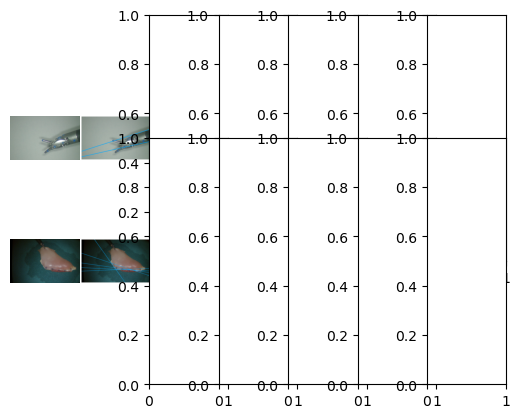

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cv2

img1 = cv2.imread('ref_data/no_contour/ref_left_img.jpg')
img2 = cv2.imread('fei_ref_data/ref_left_img.jpg')


img3 = cv2.imread('jrn_canny.png')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.imread('dtd_cannyedgelines.png')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(nrows=2, ncols=7)

#ax[0].imshow(d1_cropped, aspect = 'auto') 
#ax[0].axis('off')
#ax[1].imshow(d2_cropped, aspect = 'auto')
#ax[1].axis('off')

ax[0, 0].imshow(img1) 
ax[0, 0].axis('off')
#ax[0, 0].set_title('SOLD2', fontsize = 6)
ax[0, 1].imshow(img3)
ax[0, 1].axis('off')
#ax[0, 1].set_title('Canny', fontsize = 6)
ax[1, 0].imshow(img2)
ax[1, 0].axis('off')
ax[1, 1].imshow(img4)
ax[1, 1].axis('off')

plt.subplots_adjust(hspace = -0.5, wspace = -0.12)
plt.savefig('shaft_detection.pdf', bbox_inches = 'tight')

JRN Dataset: 2D

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#df = pd.read_csv('ref_data/no_contour/keypoint_labels_v3.csv', header = None, names = ['t', 'video_frame', 'x', 'y'])
#df['t'] = df['t'].astype('int')
#df['video_frame'] = df['video_frame'].astype('int')
#df['x'] = df['x'].astype('int')
#df['y'] = df['y'].astype('int')
#grouped = df.groupby('t', as_index = False)
#df = grouped.mean().copy()
#df.to_pickle('ref_data/no_contour/keypoint_labels_v3.pkl')
labels = np.load('ref_data/no_contour/keypoint_labels_v3.pkl', allow_pickle = True)
labels.head()

,t,video_frame,x,y
0,1593038951110543702,1.0,149.266667,152.033333
1,1593038951153185483,2.0,148.000000,148.500000
2,1593038951176389199,3.0,148.000000,150.750000
3,1593038951249043615,5.0,148.250000,151.500000
4,1593038951274473341,6.0,150.250000,145.500000


In [28]:

canny = pd.read_csv('ref_data/no_contour/canny_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])

endpi2p = pd.read_csv('ref_data/no_contour/endpoint_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])

endpi = pd.read_csv('ref_data/no_contour/endpoint_intensities_only_accuracy.txt', sep = ',', header = None, nnames = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi.head()


,t,video_frame,x,y,x_d,y_d
0,1593038951110543702,1,128,143,NaN,NaN
1,1593038951114951812,2,135,145,NaN,NaN
2,1593038951114985667,3,138,147,NaN,NaN
3,1593038951125150772,4,138,147,NaN,NaN
4,1593038951125191190,5,141,150,NaN,NaN


In [ ]:


endp2p = pd.read_csv('ref_data/no_contour/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])

li = pd.read_csv('ref_data/no_contour/line_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])

li2p = pd.read_csv('ref_data/no_contour/line_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])


df_list = [canny, endpi2p, endpi, endp2p, li, li2p]
df_names = ['canny', 'endpi2p', 'endpi', 'endp2p', 'li', 'li2p']

for i in range(len(df_list)):
    df_list[i].drop(columns=['video_frame', 'x_d', 'y_d'], inplace = True)
    df_list[i]['t'] = df_list[i]['t'].astype('int')
    grouped = df_list[i].groupby('t', as_index = False)
    df = grouped.mean().copy()

    column_name1 = 'x_' + df_names[i]
    df[column_name1] = df['x'].copy()
    column_name2 = 'y_' + df_names[i]
    df[column_name2] = df['y'].copy()
    df.drop(columns=['x', 'y'], inplace = True)
    labels = pd.merge(left = labels, right = df, on = 't')
    column_name3 = df_names[i] + '_d'
    labels[column_name3] = np.sqrt((labels['x'] - labels[column_name1])**2 + (labels['y'] - labels[column_name2])**2)
    column_name4 = df_names[i] + '_d_cumsum'
    labels[column_name4] = labels[column_name3].cumsum()
    print('{} mean: {}, std: {}'.format(column_name3, labels[column_name3].mean(), labels[column_name3].std()))
   
labels.head()
plt.xlabel('t')
plt.ylabel('Cumulative Error (px)')
plt.title('2D Accuracy: Structured Dataset')
plt.plot(np.arange(len(labels)), labels['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
plt.plot(np.arange(len(labels)), labels['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
plt.plot(np.arange(len(labels)), labels['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
plt.plot(np.arange(len(labels)), labels['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
plt.plot(np.arange(len(labels)), labels['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
plt.plot(np.arange(len(labels)), labels['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
plt.legend()

labels_SD = labels.copy()

Fei Dataset: 2D

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('fei_ref_data/keypoint_labels_v3.csv', header = None, names = ['t', 'video_frame', 'x', 'y'])
df['t'] = df['t'].astype('int')
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('t', as_index = False)
df = grouped.mean().copy()
df.to_pickle('fei_ref_data/keypoint_labels_v3.pkl')
labels = np.load('fei_ref_data/keypoint_labels_v3.pkl', allow_pickle = True)
labels.head()


,t,video_frame,x,y
0,1693289665992837088,77.0,391.0,122.0
1,1693289666032760140,78.0,392.0,123.0
2,1693289666157711306,82.0,395.0,124.0
3,1693289666462932982,91.0,394.0,125.0
4,1693289666505960720,92.0,393.0,124.0


In [ ]:

df = pd.read_csv('fei_ref_data/keypoint_labels_v2.csv', header = None, names = ['t', 'video_frame', 'x', 'y'])
df.drop(columns = ['t'], inplace = True)
df['video_frame'] = df['video_frame'].astype('int')
df['x'] = df['x'].astype('int')
df['y'] = df['y'].astype('int')
grouped = df.groupby('video_frame', as_index = False)
df = grouped.mean().copy()
labels = pd.DataFrame({'video_frame': np.arange(1, df['video_frame'].max() + 1)})
labels['video_frame'] = labels['video_frame'].astype('int')
assert(len(labels) == df['video_frame'].max())
labels = pd.merge(left = labels, right = df, how = 'left', on = 'video_frame')
assert(len(labels) == df['video_frame'].max())
labels['x'].interpolate(method = 'linear', inplace = True)
labels['x'].fillna(method = 'ffill', inplace = True)
labels['x'].fillna(method = 'bfill', inplace = True)
labels['y'].interpolate(method = 'linear', inplace = True)
labels['y'].fillna(method = 'ffill', inplace = True)
labels['y'].fillna(method = 'bfill', inplace = True)
#labels.to_pickle('fei_ref_data/keypoint_labels_v2.pkl')
labels = np.load('fei_ref_data/keypoint_labels_v2.pkl', allow_pickle = True)
labels.head()

11689
canny_d mean: 62.7287987855572, std: 24.006614534221086
endpi2p_d mean: 46.50957543600955, std: 23.756234299253325
endpi_d mean: 63.093854342871865, std: 22.952615368690594
endp2p_d mean: 62.806432477032956, std: 24.213680206960355
li_d mean: 63.09435369535788, std: 22.95276940712378
li2p_d mean: 62.806432477032956, std: 24.213680206960355


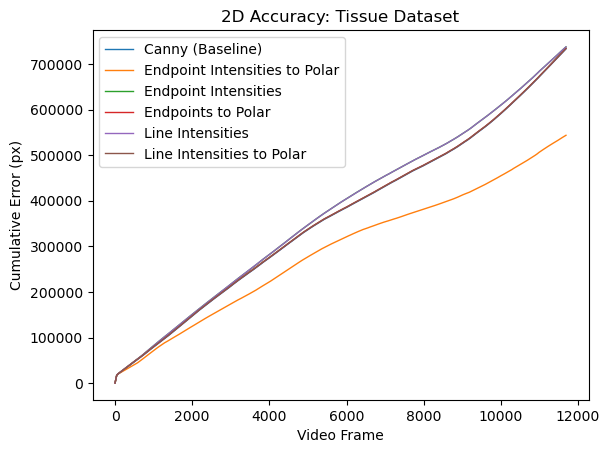

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
labels = np.load('fei_ref_data/keypoint_labels_v2.pkl', allow_pickle = True)
print(len(labels))
canny = pd.read_csv('fei_ref_data/canny_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi2p = pd.read_csv('fei_ref_data/endpoint_intensities_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endpi = pd.read_csv('fei_ref_data/endpoint_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
endp2p = pd.read_csv('fei_ref_data/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
li = pd.read_csv('fei_ref_data/line_intensities_only_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])
li2p = pd.read_csv('fei_ref_data/endpoints_to_polar_accuracy.txt', sep = ',', header = None, names = ['t', 'video_frame', 'x', 'y', 'x_d', 'y_d'])

df_list = [canny, endpi2p, endpi, endp2p, li, li2p]
df_names = ['canny', 'endpi2p', 'endpi', 'endp2p', 'li', 'li2p']

for i in range(len(df_list)):
    temp = df_list[i].copy()
    temp.drop(columns=['t', 'x_d', 'y_d'], inplace = True)
    temp['video_frame'] = temp['video_frame'].astype('int')
    temp['x'] = temp['x'].astype('int')
    temp['y'] = temp['y'].astype('int')
    grouped = temp.groupby('video_frame', as_index = False)
    temp = grouped.mean().copy()
    df = pd.DataFrame({'video_frame': np.arange(1, temp['video_frame'].max() + 1)})
    df['video_frame'] = df['video_frame'].astype('int')
    df = pd.merge(left = df, right = temp, how = 'left', on = 'video_frame')
    df['x'].interpolate(method = 'linear', inplace = True)
    df['x'].fillna(method = 'ffill', inplace = True)
    df['x'].fillna(method = 'bfill', inplace = True)
    df['y'].interpolate(method = 'linear', inplace = True)
    df['y'].fillna(method = 'ffill', inplace = True)
    df['y'].fillna(method = 'bfill', inplace = True)
    column_name1 = 'x_' + df_names[i]
    df[column_name1] = df['x'].copy()
    column_name2 = 'y_' + df_names[i]
    df[column_name2] = df['y'].copy()
    df.drop(columns = ['x', 'y'], inplace = True)
    labels = pd.merge(left = labels, right = df, on = 'video_frame', how = 'left')
    column_name3 = df_names[i] + '_d'
    labels[column_name3] = np.sqrt((labels['x'] - labels[column_name1])**2 + (labels['y'] - labels[column_name2])**2)
    column_name4 = df_names[i] + '_d_cumsum'
    labels[column_name4] = labels[column_name3].cumsum()
    print('{} mean: {}, std: {}'.format(column_name3, labels[column_name3].mean(), labels[column_name3].std()))

labels.head()
plt.xlabel('Video Frame')
plt.ylabel('Cumulative Error (px)')
plt.title('2D Accuracy: Tissue Dataset')
plt.plot(np.arange(len(labels)), labels['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
plt.plot(np.arange(len(labels)), labels['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
plt.plot(np.arange(len(labels)), labels['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
plt.plot(np.arange(len(labels)), labels['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
plt.plot(np.arange(len(labels)), labels['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
plt.plot(np.arange(len(labels)), labels['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
plt.legend()

labels_TD = labels.copy()

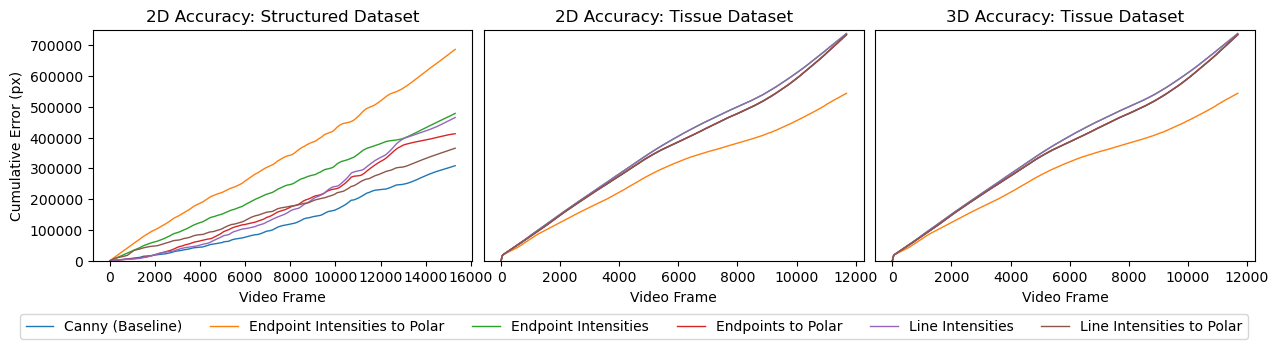

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec


fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (15, 3))

ylim = (0, 750000)

ax[0].set_xlabel('Video Frame')
ax[0].set_ylabel('Cumulative Error (px)')
ax[0].set_title('2D Accuracy: Structured Dataset')
ax[0].set_ylim(ylim)
ax[0].plot(np.arange(len(labels_SD)), labels_SD['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
ax[0].plot(np.arange(len(labels_SD)), labels_SD['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
#ax[0].legend()

ax[1].set_xlabel('Video Frame')
ax[1].set_ylabel('Cumulative Error (px)')
ax[1].set_title('2D Accuracy: Tissue Dataset')
ax[1].set_ylim(ylim)
ax[1].axes.get_yaxis().set_visible(False)
ax[1].plot(np.arange(len(labels_TD)), labels_TD['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
ax[1].plot(np.arange(len(labels_TD)), labels_TD['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
#ax[1].legend()

ax[2].set_xlabel('Video Frame')
ax[2].set_ylabel('Cumulative Error (px)')
ax[2].set_title('3D Accuracy: Tissue Dataset')
ax[2].set_ylim(ylim)
ax[2].axes.get_yaxis().set_visible(False)
ax[2].plot(np.arange(len(labels_TD)), labels_TD['canny_d_cumsum'], color = 'C0', linewidth = 1, label = 'Canny (Baseline)')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['endpi2p_d_cumsum'], color = 'C1', linewidth = 1, label = 'Endpoint Intensities to Polar')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['endpi_d_cumsum'], color = 'C2', linewidth = 1, label = 'Endpoint Intensities')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['endp2p_d_cumsum'], color = 'C3', linewidth = 1, label = 'Endpoints to Polar')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['li_d_cumsum'], color = 'C4', linewidth = 1, label = 'Line Intensities')
ax[2].plot(np.arange(len(labels_TD)), labels_TD['li2p_d_cumsum'], color = 'C5', linewidth = 1, label = 'Line Intensities to Polar')
#ax[2].legend()

plt.legend(ncol = 6, bbox_to_anchor = (1.0, -0.2))

plt.subplots_adjust(wspace = 0.03)
plt.savefig('cum_error.pdf', bbox_inches = 'tight')